
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Anual Weather Types (AWT) with perturbed probabilities (markov=1)
inputs required: 
  * Modified transition probability matrix

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.pca import PCA_LatitudeAverage
from teslakit.kma import KMA_simple
from teslakit.statistical import CopulaSimulation
from teslakit.alr import ALR_WRP

from teslakit.plotting.awt import Plot_AWTs_EOFs, Plot_AWTs, Plot_AWTs_Dates, Plot_AWTs_Validation
from teslakit.plotting.pcs import Plot_PCs_Compare_3D, Plot_PCs_WT
from teslakit.plotting.wts import Plot_Compare_Transitions



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters
num_clusters = 6
SST_AWTs = db.Load_SST_KMA()


SystemExit: 

In [5]:
# --------------------------------------
# PCs123 random generation with Copulas
PCs_fit, PCs_rnd = db.Load_SST_PCs_fit_rnd()



## Predicted AWT. Markov=1

<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 1002)
Coordinates:
  * time         (time) object 1699-06-01 00:00:00 ... 2700-06-01 00:00:00
  * n_sim        (n_sim) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
Data variables:
    evbmus_sims  (time, n_sim) float32 ...


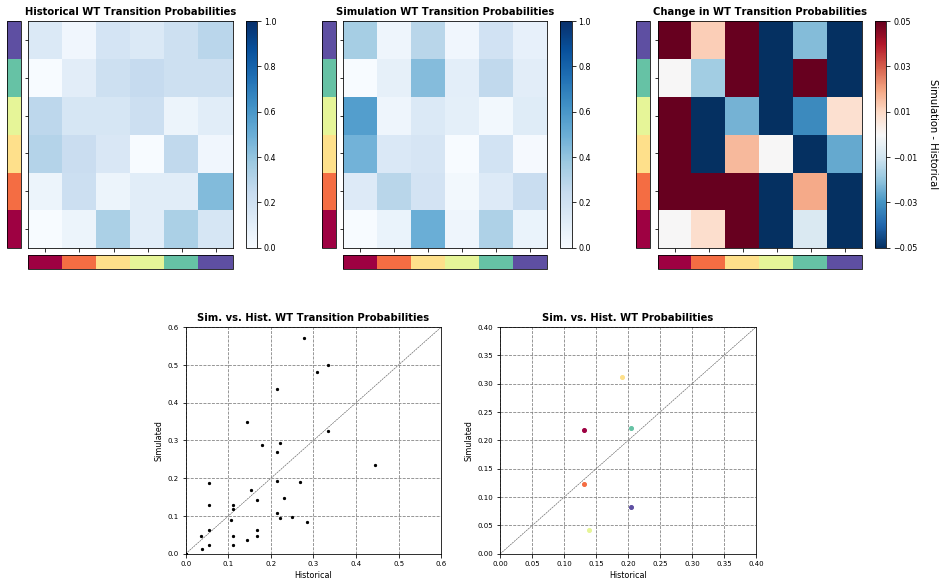

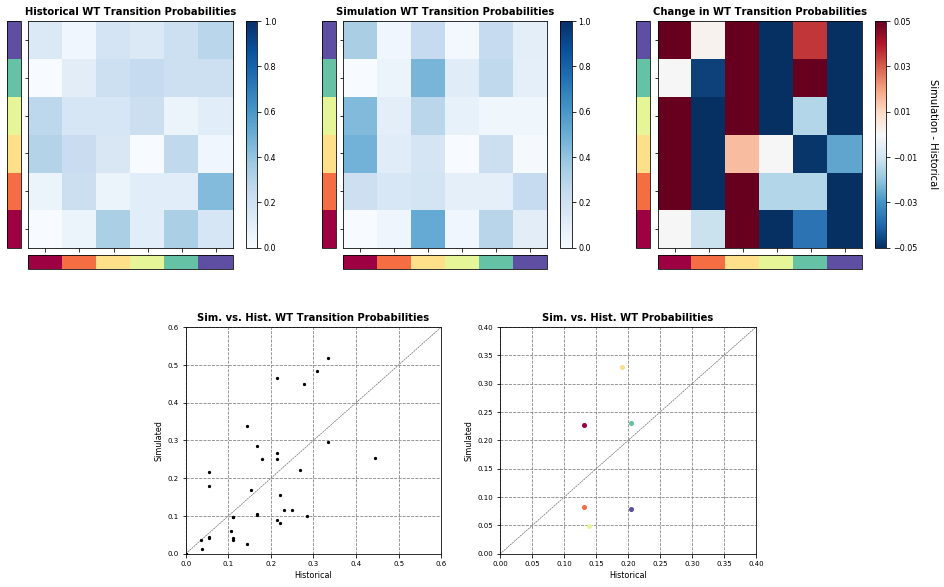

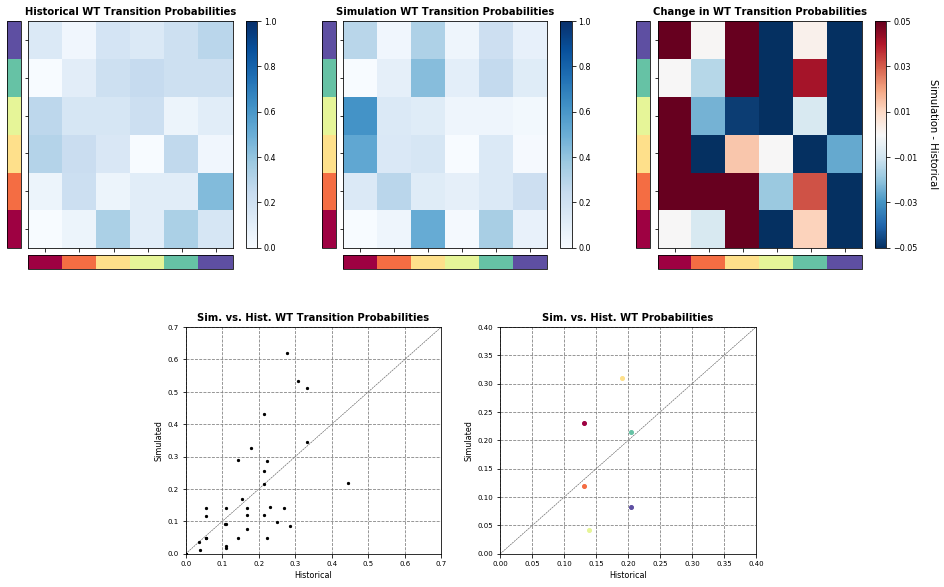

In [15]:
SST_AWTs_sim = xr.open_dataset(p_data + '/sites/ROI/SST/CC_SST_AWT_sim.nc')
print(SST_AWTs_sim)

bmus_values_hist = SST_AWTs.bmus.values+1

for s in SST_AWTs_sim.n_sim[:3]:
    
    bmus_values_sim = SST_AWTs_sim.evbmus_sims.sel(n_sim=s).values

    Plot_Compare_Transitions(num_clusters, bmus_values_hist, bmus_values_sim,
                                 sttl=None, show=True)

In [16]:
vari = SST_AWTs.variance.values[:]

# --------------------------------------
# PCs generation

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]
        
    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : SST_AWTs_sim.evbmus_sims.time.values}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
from teslakit.io.aux_nc import StoreBugXdset
StoreBugXdset(SST_PCs_sim, p_data + '/sites/ROI/SST/CC_SST_PCs_sim.nc')



<xarray.Dataset>
Dimensions:     (n_sim: 10, time: 1002)
Coordinates:
  * time        (time) object 1699-06-01 00:00:00 ... 2700-06-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 35.79 -2.923 11.01 ... 10.87 -39.49 39.33
    PC2         (n_sim, time) float64 14.21 0.5072 5.256 ... 10.2 0.5265 -6.664
    PC3         (n_sim, time) float64 -8.391 -12.26 9.279 ... 2.541 8.704 11.08
    evbmus_sim  (n_sim, time) float32 2.0 3.0 2.0 6.0 1.0 ... 3.0 2.0 6.0 1.0
